In [1]:
import torch
from torchvision import datasets, transforms as T
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
import torchvision.models as models
from matplotlib import pyplot
import numpy as np
import json
import cv2 as cv
import torch.nn.functional as F

normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
#load ImageNet validation data
transform = T.Compose([T.Resize((224, 224)),
                       T.ToTensor()
                       #normalize
                      ])

#input image
input_image = datasets.ImageFolder(root='/home/jason/Uni/multimedia_project/data/', 
                               transform=transform)

#y labels
filepath = 'ILSVRC2015_clsloc_validation_ground_truth.txt'

def get_valid_label(filepath):
    label_list = []
    with open(filepath, 'r') as f:
        ctx = f.readlines()
        for tmp in ctx:
            label_list.append(int(tmp.rstrip('\n')))
                              
    return label_list
                              
y = get_valid_label(filepath)

testloader = DataLoader(input_image, batch_size=1, shuffle=True, num_workers=2)

#load imagenet label
with open('labels.json') as f:
    label = json.load(f)
    f.close()


In [2]:
#image plot help function
def plot_multiple(images, titles, colormap='gray', max_columns=np.inf, share_axes=True):
    """Plot multiple images as subplots on a grid."""
    assert len(images) == len(titles)
    n_images = len(images)
    n_cols = min(max_columns, n_images)
    n_rows = int(np.ceil(n_images / n_cols))
    fig, axes = pyplot.subplots(
        n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2),
        squeeze=False, sharex=share_axes, sharey=share_axes)

    axes = axes.flat
    # Hide subplots without content
    for ax in axes[n_images:]:
        ax.axis('off')
        
    if not isinstance(colormap, (list,tuple)):
        colormaps = [colormap]*n_images
    else:
        colormaps = colormap

    for ax, image, title, cmap in zip(axes, images, titles, colormaps):
        ax.imshow(image, cmap=cmap)
        ax.set_title(title)
        
    fig.tight_layout()

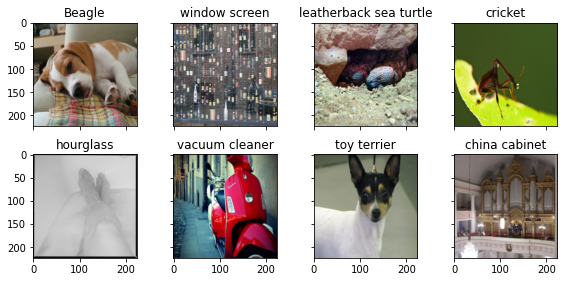

In [3]:
#import pre trained model
model = models.resnet18(pretrained=True)
#set the model to evaluate mode
model.eval()

def predict_image(num=8, coloum = 4):
    titles = []
    images = []
    for _ in range(num):
        image = iter(testloader).next()
        x = model(image[0])
        result = torch.argmax(x)
        npimg = np.array(image[0]).squeeze()
        images.append(np.transpose(npimg, (1, 2, 0)))
        titles.append(label[result])
    plot_multiple(images, titles, max_columns=4)
predict_image()

In [4]:
def generate_random_image():
    image = iter(testloader).next()
    return image[0]

In [5]:
#using grad hook and feature hook to get gradient and feature map
def gradhook(module, grad_input, grad_output):
    gradList.append(grad_output)

def featurehook(module, input, output):
    featureList.append(output)

#get the gradient value by using hook
gradList = []
featureList = []
    
# output original image list and heatmap image list
def generate_heat_map_image(model):
    gradList.clear()
    featureList.clear()
    
    #link the hook back the model
    model.layer4.register_backward_hook(gradhook)
    model.layer4.register_forward_hook(featurehook)

    #get a random image
    image = generate_random_image()
    out = model(image)
    result = torch.argmax(out)
    title = label[result]
    loss = torch.sum(F.log_softmax(out, -1), -1)
    mean_loss = loss.mean()

    #generate the gradient via back propagation
    mean_loss.backward()
    
    #covert to numpy image
    npimg = np.array(image).squeeze()
    originimg = np.transpose(npimg, (1, 2, 0))
    
    #calculate the weight of global average pooling of the gradient 
    a = gradList[0][0].squeeze()
    a = torch.nn.functional.max_pool2d(a, a.shape[1]) # weight
    
    #normalize weight and apply relu as activatiom map
    weight = a / torch.sum(a)
    weight = torch.nn.functional.relu(weight)
    weight = weight.detach().numpy().squeeze()
    feature = featureList[0][0].detach().numpy()
    
    #generate the heatmap
    heatmap = np.zeros_like(feature[0])
    for coef, tmp in zip(weight, feature):
        heatmap += tmp*coef
    heatmap = heatmap * 255
    heatmap = cv.resize(heatmap, (224, 224), interpolation=cv.INTER_CUBIC)
    
    #bin equalization to adjust the contrast ratio
    lowerbound = heatmap.min()
    higherbound = heatmap.max()
    totalRange = higherbound - lowerbound
    heatmap = (heatmap - lowerbound) / totalRange * 255
    
    #covert the color map
    heatmap = heatmap.astype(np.uint8)
    return originimg, heatmap, title

In [6]:
img, heat, title = generate_heat_map_image(model)

def plot_result(num=2):
    imglist = []
    titlelist = []
    cmaplist = []
    outputtitle = []
    for idx in range(8):
        img, heat, title = generate_heat_map_image(model)
        imglist.append(img)
        imglist.append(heat)
        titlelist.append(title )
        titlelist.append(' heat')
        cmaplist.append('gray')
        cmaplist.append('Accent')
        pyplot.imsave('./{}-{}'.format(idx, 'origin.jpg'), img)
        pyplot.imsave('./{}-{}'.format(idx, 'heat.jpg'), heat, cmap='Accent')
        outputtitle.append(title)
        
    plot_multiple(imglist, titlelist, cmaplist, num)
    return outputtitle

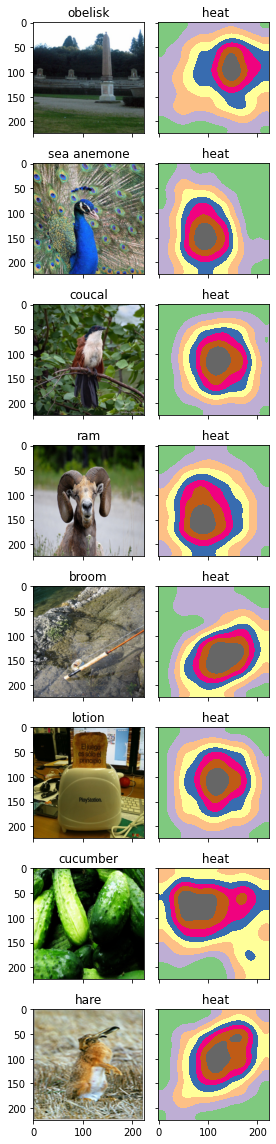

In [7]:
titlelist = plot_result()

In [8]:
def plot_merge_heatmap(titlelist):
    outputlist = []
    imglist = []
    for idx in range(8):
        #define path
        oripath = './{}-{}'.format(idx, 'origin.jpg')
        heatpath = './{}-{}'.format(idx, 'heat.jpg')
        
        #get original image
        ori = cv.imread(oripath, cv.IMREAD_COLOR)
        tmp_ori = cv.cvtColor(ori, cv.COLOR_RGB2BGR)
        imglist.append(tmp_ori)
        outputlist.append('{}'.format(titlelist[idx]))
        
        
        #get combined image
        heat = cv.imread(heatpath, cv.IMREAD_COLOR)
        heat_tmp = cv.cvtColor(heat, cv.COLOR_RGB2BGR)
        imglist.append(heat_tmp)
        outputlist.append('{}'.format('heatmap'))
        
        cv.addWeighted(ori, 0.5, heat, 0.5, 0, heat)
        combinedpath = './{}-{}'.format(idx, 'combined.jpg')
        cv.imwrite(combinedpath, heat)
        tmp = cv.cvtColor(heat, cv.COLOR_BGR2RGB)
        imglist.append(tmp)
        outputlist.append('{}'.format('combine'))

    plot_multiple(imglist, outputlist, max_columns= 3)
    

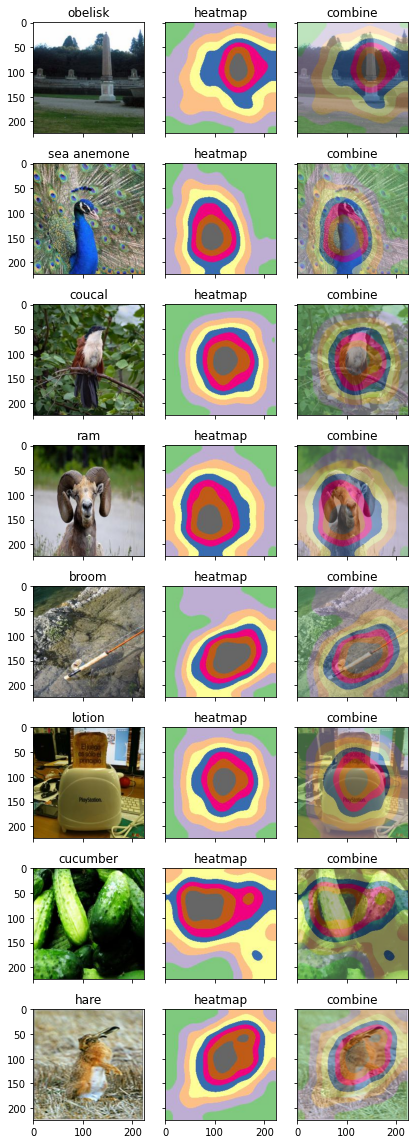

In [9]:
plot_merge_heatmap(titlelist)